# Compression Anonymity

This notebook explores several avenues of using compression and common compression schemes to provide anonymity and privacy. First, we'll write a simple implementation of Huffman encoding, but make it generic enough so that it can be tweaked to provide privacy instead of compression.

# Preliminaries

Before writing any code for privacy, we'll need the basic data structures and building blocks we're going to use throughout this notebook to write the compression algorithms.

## Setup

In [2]:
-- :ext RebindableSyntax
-- :ext NoImplicitPrelude
-- :ext UnicodeSyntax
-- :opt svg

-- import Privacy.Prelude

-- default (Natural, Integer, Word, Int, Ratio Natural, Rational, Double)

import Data.Tree.Perfect
                
tr = makePerfect 3 ' '
                
let rtr = foldr ($) tr (zipWith (incr . const) ['a'..] [0,3,2,6])

import Text.PrettyPrint

prettyPerfectTree (brackets . char) rtr



[4 [3 [1 [a]
         [ ]]
      [2 [c]
         [b]]]
   [1 [0 [ ]
         [ ]]
      [1 [d]
         [ ]]]]

## Algebras

We'll rely on three main concepts to generalize the compression algorithms.

### Information

When anonymizing information, we'll need a general way to talk about the "information" a set contains. This is well represented by an information algebra: it's similar to a measure on a set, but has fewer constraints. We'll represent it here as a simple function:

In [2]:
type Information a b = a -> b

The simplest type of "information" is the number of elements a set contains. (the "counting" measure)

In [3]:
:ext GeneralizedNewtypeDeriving

import Graphics.Rendering.Chart.Plot.Bars (BarsPlotValue)
import Graphics.Rendering.Chart.Axis.Types (PlotValue)

newtype Count
    = Count
    { getCount :: Natural
    } deriving (Eq,Ord,NaturalLiteral,PlotValue,BarsPlotValue)
    
instance Show Count where
    showsPrec n (Count x) = showsPrec n x

count :: Information a Count
count _ = Count 1

Two useful other notions of information are ranges:

In [4]:
data Range a
    = a :≤..≤: a
    deriving (Eq, Ord)

range :: Information a (Range a)
range x = x :≤..≤: x

instance (Show a, Eq a) => Show (Range a) where
    show (lb :≤..≤: ub)
        | lb == ub = show lb 
        | otherwise = "[" ++ show lb ++ "," ++ show ub ++ "]"

instance NaturalLiteral a => NaturalLiteral (Range a) where
    fromNatural = range . fromNatural

And the set of unique elements:

In [5]:
import Data.Set (Set)
import qualified Data.Set as Set

elements :: Information a (Set a)
elements = Set.singleton

### Semirigs

When manipulating information, we'll often want to generalize and focus on information. Generalization is encapsulated by a semigroup:

In [6]:
instance Semigroup Count where
    (<>) = (+) `ala` getCount

instance Ord a => Semigroup (Range a) where
    xl :≤..≤: xu <> yl :≤..≤: yu = min xl yl :≤..≤: max xu yu

For sets, generalization is union.

We will also need to refine: the dual of generalization. For this, we'll use a semirig.

Semirigs go by several different definitions in the literature: here we'll only require 2 operations. $+$ (generalization), and $\times$ for refinement. They include the usual associativity and distributivity laws.

In [7]:
instance Ord a => Semirig (Range a) where
    (+) = (<>)
    xl :≤..≤: xu * yl :≤..≤: yu = max xl yl :≤..≤: min xu yu

For sets, the refinement operation is intersection.

Using these, we can generalize sets of values to their information:

In [8]:
:ext TypeApplications
:ext DataKinds

generalizeTo count (nonEmpty @ [1,2,3,4,5])

5

In [9]:
generalizeTo range (nonEmpty @ [4,2,1,3,5])

[1,5]

Using these types we can generate a histogram:

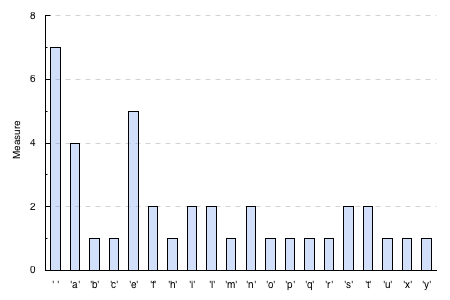

In [10]:
import Algebra.Information.Histogram

generalizeTo
    (histogramOf count)
    (nonEmptyString @ "this is an example of a frequency table")

We'll display histograms of continuous data slightly differently:

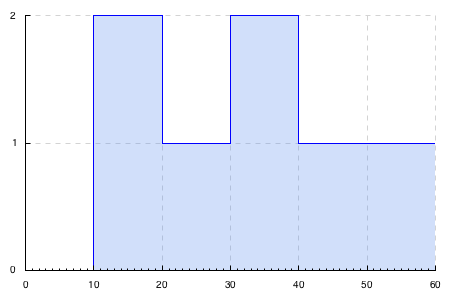

In [11]:
import Graphics.Rendering.Chart.Plot.Histogram.Simple

contHist 10 0 [36,38,27,52,15,13,44]

### Measures

In order to compare the "weight" of one information to another, we'll need a way to order them.

In [12]:
import Data.Functor.Contravariant

rangeSize :: (Semirig a, Ord a) => Comparison (Range a)
rangeSize
    = Comparison
        (\(xl :≤..≤: xu) (yl :≤..≤: yu) -> compare (xu + yl) (yu + xl))

smaller :: Comparison a -> a -> a -> Bool
smaller (Comparison cmp) x y = cmp x y == LT

smaller rangeSize (3 :≤..≤: 4) (1 :≤..≤: 5)

lte :: Comparison a -> a -> a -> Bool
lte (Comparison cmp) x y = cmp x y /= GT

lte rangeSize (1 :≤..≤: 5) (1 :≤..≤: 5)
lte rangeSize (1 :≤..≤: 6) (1 :≤..≤: 5)

True

True

False

We can also have an ordering for diversity:

In [13]:
diversity :: Comparison (Set a)
diversity = Comparison (comparing Set.size)

smaller diversity
    (generalizeTo elements (nonEmpty @ [1, 2, 2]))
    (generalizeTo elements (nonEmpty @ [1, 2, 3]))

True

## Data Structures

### A Binary Tree

This is the tree we'll use for both the encoding and anonymization algorithms. It caches the information of its subtrees: we'll use that information in both building and decoding the anonymized form.

In [14]:
import Algebra.Information.Tree

We can draw the tree, with the measures of subtrees at each node:

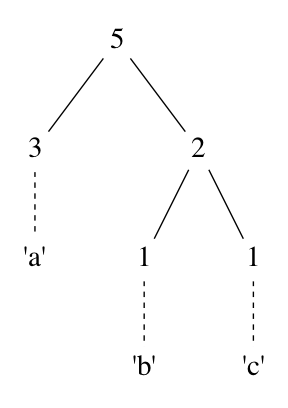

In [15]:
smallTree :: Tree Natural Char
smallTree = Node 5 (Leaf 3 'a') (Node 2 (Leaf 1 'b') (Leaf 1 'c'))
smallTree

And we can find out the paths for items in the tree:

In [16]:
import qualified Data.Map.Strict as Map

import           Text.Html.Table
import qualified Text.Blaze.Html5 as Tag
import qualified Text.Blaze.Html5.Attributes as Attr

import           GHC.Exts (fromString)

table ("Value", "Path")
      (mempty , Attr.style (fromString "text-align: left;"))
      (Map.toList (codeBook smallTree))

Value,Path
a,0
b,10
c,11


### A Priority Queue

A pairing heap \cite{fredman_pairing_1986} is simple to implement, and works well as a priority queue. Both the `merge` and `insertHeap` functions below are amortized $\mathcal{O}(1)$, and `minView` is amortized $\mathcal{O}(\log n)$.

In [17]:
import Data.Heap.Pairing

# Huffman Encoding

We're now able to write the algorithm for Huffman compression.

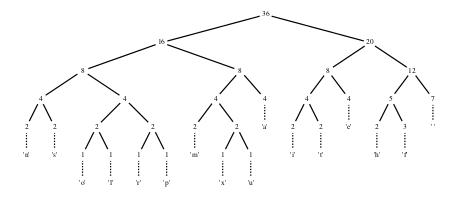

Original,Code
e,101
x,01010
a,011
m,0100
p,00111
l,00101
e,101


In [18]:
import Data.Maybe

buildHuffman :: Semigroup a
             => Comparison a
             -> Heap a (Tree a b) -> Tree a b
buildHuffman order hp = case minView (lte order) hp of
    (_,x,Nothing) -> x
    (i,x,Just xs) -> case minView (lte order) xs of
        (j,y,Nothing) -> Node (i <> j) x y
        (j,y,Just ys) ->
            buildHuffman
                order
                (insertHeap (lte order) (i <> j) (Node (i <> j) x y) ys)

buildHeap :: Comparison a -> Histogram a b -> Heap a (Tree a b)
buildHeap order
    = fromJust
    . Map.foldlWithKey' f Nothing
    .# getHistogram
  where
    f hp k v = Just (maybe (singleton v leaf)
                           (insertHeap (lte order) v leaf) hp)
      where
        leaf = Leaf v k

huffmanTree :: (Ord a, Semigroup b, Foldable1 f)
            => Comparison b
            -> Information a b
            -> f a
            -> Tree b a
huffmanTree order info
    = buildHuffman order
    . buildHeap order
    . generalizeTo (histogramOf info)

tree
    = huffmanTree
      defaultComparison
      count
      (nonEmptyString @ "this is an example of a huffman tree")
tree

huffmanEncode :: (Ord a, Foldable f)
              => Tree c a
              -> f a
              -> Table [a, Path]
huffmanEncode tr xs =
    table ("Original", "Code")
          (Attr.style (fromString "text-align: center;")
          ,Attr.style (fromString "text-align: left;"))
          [(x, mp Map.! x) | x <- toList xs ]
  where
    mp = codeBook tr

huffmanEncode tree "example"

## Huffman Anonymity

Huffman compression has a ready analogue in the form of $k$-anonymity <cite data-cite="2201627/S5ZJQFX5"></cite>. By truncating the output of the Huffman compression, rows which occur fewer than $k$ times are not specified: instead, a prefix (which could correspond to some $n$ rows, $n \geq k$) is provided.

Taken from a different perspective, we build a Huffman tree from the rows in our database. Then, for each value in the database, we walk down the tree from root to the corresponding leaf, stopping if we hit a node that contains fewer than $k$ entries. Then, we output the summary of values at that point.

This general procedure forms the basis for several of the anonymization algorithms.

First, for data, let's use ages:

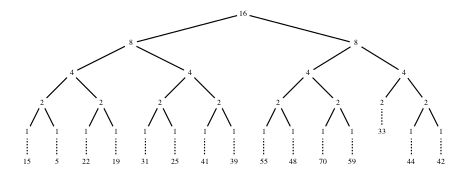

In [19]:
ages = nonEmpty @ [5,15,19,22,25,33,33,39,31,44,41,42,48,55,59,70]

agesTree = huffmanTree defaultComparison count ages
agesTree

We can draw the privatized version of the tree: the faded sections aren't revealed, and the node above each faded section is what's released instead. We'll use $k=2$ for this running example.

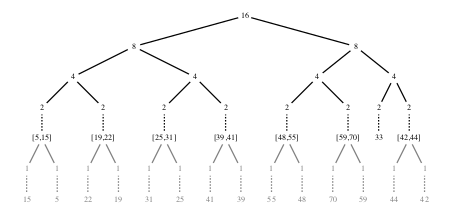

In [20]:
privateTree (>=2) range agesTree

This demonstrates an immediate problem with Huffman anonymity: ages are grouped together with values that are unrelated, yielding unsatisfactory generalizations.

The procedure for using the above tree as a model for $k$-anonymizing a dataset is as follows: first we prune the tree, using some predicate to indicate at what level we should stop:

In [21]:
prune :: (Alternative f)
      => (Tree a b -> f c)
      -> Tree a b
      -> f (Tree a c)
prune select tr@(Node i l r)
    =   liftA2 (Node i) (prune select l) (prune select r)
    <|> fmap (Leaf i) (select tr)
prune select tr@(Leaf i _) = Leaf i <$> select tr

The `select` parameter to the function indicates when to stop walking down the tree. For Huffman $k$-anonymity, this will just measure the size of the tree.

Next, to construct a mapping:

In [22]:
anonMapping :: Ord b
            => (a -> Bool)
            -> (Tree a b -> c)
            -> Tree a b
            -> Maybe (Histogram c b)
anonMapping reveal private = fmap (Histogram #. fold) . prune (\tr -> do
    guard (reveal (measure tr))
    let generalization = private tr
    pure (foldMap (\x -> Map.singleton x generalization) tr))

From this, we can anonymize the original table:

In [23]:
import           IHaskell.Display        (IHaskellDisplay(display)
                                         ,html,Display)
import           Data.Functor.Identity

anonTable :: (Applicative m, Ord a, Show a, Foldable f)
          => (b -> m String)
          -> Histogram b a
          -> f a
          -> m (Table [a, String])
anonTable output (Histogram mapping) xs'
    = fmap toTable (traverse (\x -> output (mapping Map.! x)) xs)
  where
    xs = toList xs'
    toTable strs
        = table ("Original", "Anonymized")
                (Attr.style (fromString "text-align: center;")
                ,Attr.style (fromString "text-align: center;"))
                (zip xs strs)

anonTablePure :: (Ord a, Show a, Show b, Foldable f)
              => Histogram b a
              -> f a
              -> Table [a, String]
anonTablePure hist = runIdentity #. anonTable (pure #. show) hist

anonTablePure (fromJust $
    anonMapping (2<=) (generalizeTo range) agesTree) ages

Original,Anonymized
5,"[5,15]"
15,"[5,15]"
19,"[19,22]"
22,"[19,22]"
25,"[25,31]"
33,33
33,33
39,"[39,41]"
31,"[25,31]"
44,"[42,44]"


Better generalizations can be achieved by building an *alphabetic* Huffman tree <cite data-cite="2201627/M35JL7I9"></cite>.

In [ ]:
:ext FlexibleContexts

import           Control.Monad.State
import qualified Data.Map.Strict     as Map
import           Data.Foldable       (Foldable(..))
import           Algebra.Information.Huffman.Alphabetic (optAlphTree)
import           Data.Bifunctor (first)

buildAlphHuffman :: Histogram Count a -> Tree Count a
buildAlphHuffman xs = evalState (go c) (Map.toList (getHistogram xs))
  where
    c = fromEnum (sum (getCount <#$> getHistogram xs))
    go n = do
      (x,Count i) <- gets head
      if fromEnum i >= n
        then do
          modify tail
          pure (Leaf (Count i) x)
        else do
          let m = n `div` 2
          ls <- go m
          let nxt = n - fromEnum (getCount (measure ls))
          if nxt <= 0 then pure ls else do
            rs <- go nxt
            pure (Node (measure ls <> measure rs) ls rs)
            
buildOptAlphHuffman :: Ord a => Histogram Count a -> Tree Count a
buildOptAlphHuffman xs
    = first (Count . toEnum) 
    $ optAlphTree
    [ (fromEnum i, x)
    | (x,Count i) <- Map.toList (getHistogram xs) ]

alphHuffmanTree :: (Foldable1 f, Ord a) => f a -> Tree Count a
alphHuffmanTree = buildAlphHuffman . generalizeTo (histogramOf count)

k2agesAlph = privateTree (>=2) range (alphHuffmanTree ages)
k2agesAlph

anonTablePure (fromJust $
    anonMapping (2<=) (generalizeTo range) agesTree) ages

Building an optimal alphabetic Huffman tree can be done in $\mathcal{O}(n \log n)$ time, however the above approach is *not* optimal. It simply splits the input at as close to halfway as possible (according to the weights of the values), and proceeds recursively on each subdivision. In this way, it mimics the Shannon-Fano algorithm.

There are a few variations on the theme of building optimal trees like the above <cite data-cite="2201627/3ZHU4IMM"></cite>: the "optimal alphabetic tree problem" is when we have the probabilities of accessing each key. When you also have the probabilities of accessing a key in the gap between two successive keys (which isn't in the tree), you are dealing with the "optimal binary search tree" problem. 

# Arithmetic Coding for Privacy

Arithmetic coding compresses data by encoding successively smaller and smaller intervals. For our purposes, it has two properties which are desirable:

* It is a streaming algorithm, able to output the encoding for an input symbol once it has been received.
* It parameterizes the notion of a "model": for compression, this allows intelligent prediction of things like "a u is likely to come after a q" (when compressing English text). Commonly, it facilitates the building of a frequency table on the fly. For our purposes, it will both build the frequency table on-the-fly, and potentially allow us to cluster similar data together.

In order to use the algorithm for privacy, we will first emit a sequence of intervals, instead of a single number. This removes the capacity for compression. For instance, for the letters $a,b,c$, the following might be emitted:

$$\frac{1}{3},\frac{1}{3},\frac{1}{3}$$

Secondly, we will use a model that builds a cumulative frequency table on the fly (e.g. with a Fenwick tree). This widens the interval for more frequently occurring symbols.

Thirdly, we will truncate the output of the representation of each interval. In other words, we will widen every interval. The amount we widen by will be the minimum amount to make the interval larger than $\frac{k}{n}$ where $n$ is the number of symbols seen so far.

Finally, we will decompress as we compress, translating the intervals back into the values of the domain we are anonymizing. Because we have truncated the interval, it may span more than one value in our model. This is desired: it will happen only when $k$ is satisfied only through generalization.

As a simple way to demonstrate the algorithm, we will use a perfect binary tree to count the cumulative frequencies:

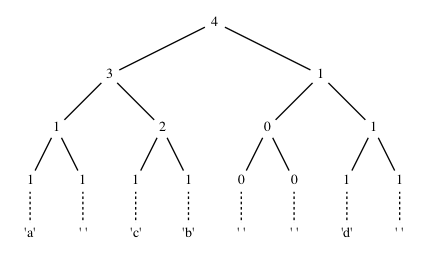

In [25]:
import Data.Tree.Perfect
                
tr = makePerfect 3 ' '
                
foldr ($) tr (zipWith (incr . const) ['a'..] [0,3,2,6])

Then, we can write a function that looks up an item in the tree *up until* the point where $k$ is no longer satisfied. The advantage of this approach is that it maintains $k$-anonymity incrementally. Take, for instance, this small list of values between $0$ and $4$:

In [26]:
smallVals = [1,2,1,3,2,0,1,0,3]

import Data.Traversable (mapAccumL)
import Data.List        (inits)

incrementalAnon :: Int -> Word -> [Word] -> [[Span]]
incrementalAnon k sz xs
    = snd 
    $ mapAccumL
        anon
        (makePerfect sz ())
        (zip xs (tail (inits xs)))
  where
    anon tr (v,vs) = (i,traverse (subTree k) vs i)
      where
        i = incr id v tr

mapM_ print (incrementalAnon 2 2 [1,2,1,3,2,0,1,0,3])

[[0,4)]
[[0,4),[0,4)]
[[0,4),[0,4),[0,4)]
[[0,2),[2,4),[0,2),[2,4)]
[[0,2),[2,4),[0,2),[2,4),[2,4)]
[[0,2),[2,4),[0,2),[2,4),[2,4),[0,2)]
[[0,2),[2,4),[0,2),[2,4),[2,4),[0,2),[0,2)]
[1,[2,4),1,[2,4),[2,4),0,1,0]
[1,2,1,3,2,0,1,0,3]

# Incremental Anonymity

Incrementally anonymizing a database can potentially leak private data <cite data-cite="2201627/HWXFFBRT"></cite>. For instance, take the following values:

In [27]:
oldDatabase = nonEmpty @ [1,2,3,4,5]

anonTablePure (fromJust $
    anonMapping (2<=) (generalizeTo range)
                      (alphHuffmanTree oldDatabase)) oldDatabase

Original,Anonymized
1,"[1,2]"
2,"[1,2]"
3,"[3,5]"
4,"[3,5]"
5,"[3,5]"


If another $3$ is added to the database:

In [28]:
newDatabase = nonEmpty @ [1,2,3,4,5,3]

anonTablePure (fromJust $
    anonMapping (2<=) (generalizeTo range)
                      (alphHuffmanTree newDatabase)) newDatabase

Original,Anonymized
1,"[1,3]"
2,"[1,3]"
3,"[1,3]"
4,"[4,5]"
5,"[4,5]"
3,"[1,3]"


If both of these anonymizations are released, we could take their row-wise intersection, thereby revealing much more information than we intended.

In [29]:
Just intersection = anonMapping (2<=) (generalizeTo range)
                                      (alphHuffmanTree oldDatabase)
                  * anonMapping (2<=) (generalizeTo range)
                                      (alphHuffmanTree newDatabase)

anonTablePure intersection oldDatabase

Original,Anonymized
1,"[1,2]"
2,"[1,2]"
3,3
4,"[4,5]"
5,"[4,5]"


The solution might seem simple: just don't change the anonymization of previous entries. But this is actually sub-optimal, leaving earlier more conservative than they need to be.

The problem is related to *tree-balancing*. For search trees, we want to balance to reduce search cost, but reduce the frequency of balancing to reduce insertion cost: here, we want to balance to increase information gain, but reduce frequency of balancing to avoid revealing private internal structure.

It's worth noting that we're not concerned with the overall frequency of balances, rather the rebalancing per release. After all, if we only release one copy of the anonymized data set, we need not be concerned with incremental privacy at all.

# Generalized Balance

In the previous section, we saw that we could generalize the "cost of rebalancing" to describe incremental anonymity. Other notions from the theory of search trees can be generalized similarly, in particular *balance*.

One generalization applies to $l$-diversity <cite data-cite="2201627/E9354EJL"></cite>.

Let's take a database with a sensitive row, perhaps voting preference:

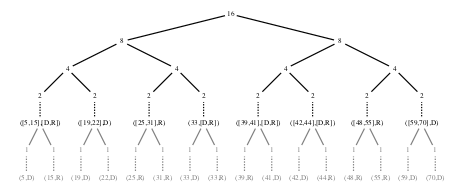

Original,Anonymized
"( 5 , D )","([5,15],[D,R])"
"( 15 , R )","([5,15],[D,R])"
"( 19 , D )","([19,22],D)"
"( 22 , D )","([19,22],D)"
"( 25 , R )","([25,31],R)"
"( 33 , D )","(33,[D,R])"
"( 33 , R )","(33,[D,R])"
"( 39 , R )","([39,41],[D,R])"
"( 31 , R )","([25,31],R)"
"( 44 , R )","([42,44],[D,R])"


In [30]:
:ext TypeOperators

import Control.Arrow ((***))
import Text.Printf   (PrintfArg(..),formatChar)
import qualified Data.List.NonEmpty as NonEmpty

data VotingPref
    = D
    | R
    deriving (Show,Eq,Ord)

instance Tag.ToMarkup VotingPref where
    toMarkup D = Tag.toMarkup 'D'
    toMarkup R = Tag.toMarkup 'R'

instance (Tag.ToMarkup a, Tag.ToMarkup b) => Tag.ToMarkup (a,b) where
    toMarkup (x,y) = Tag.toMarkup '('
                  <> Tag.toMarkup x
                  <> Tag.toMarkup ','
                  <> Tag.toMarkup y
                  <> Tag.toMarkup ')'

agesAndVotes = NonEmpty.zip ages (D :| [R,D,D,R,D,R,R,R,R,D,D,R,R,D,D])
privateTree (2<=) (range *** range) (alphHuffmanTree agesAndVotes)
anonTablePure (fromJust $
    anonMapping (2<=) (generalizeTo (range *** range))
                      (alphHuffmanTree agesAndVotes)) agesAndVotes

As you can see, while $k$-anonymity has indeed been preserved, most rows in the table have had their voting preference revealed. To counteract that, we can balance the voting preference when building the tree: however, this ups the complexity of the procedure.

# Randomization

Providing an equivalence class for each $k$-anonymous value is problematic in 2 ways:

* It allows an adversary to intersect the members of this class with future releases, revealing more information that originally intended.
* It doesn't provide distribution information on the members of the class.

While we could remedy the second point by providing a histogram instead of a set, but that would exacerbate the problem of the first.

Instead, we can randomize the output from the tree traversal, providing a concrete value that may have noise added in the output. This will allow us to output a representative table, with the distributions similar to the private table, but also it will hide the equivalence groupings we use in the tree, allowing us to aggressively rebalance when necessary.

This concept maps on to differential privacy.

There are several ways to use the tree to provide differential privacy.

Firstly, the tree allows us to easily compute accurate samples from the database:

In [31]:
import Control.Monad.Random.State
import System.Random

select :: (RandomGen g, Monad m) => Tree Count a -> RandT g m a
select (Leaf _ x)   = pure x
select (Node _ l r) = choose (getCount (measure l)) (getCount (measure r))
                  >>= bool (select l) (select r)

With some random input:

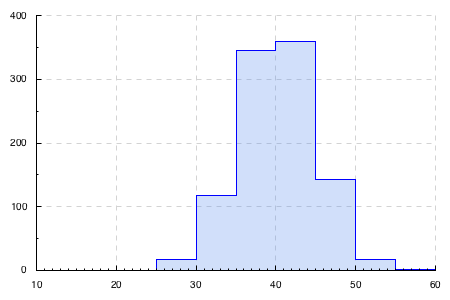

In [32]:
import Statistics.Distribution.Normal
import System.Random.MWC
import Statistics.Distribution

randVar :: IO Int
randVar = fromEnum <$>
    withSystemRandom (genContVar (normalDistr 40 5) `asTypeOf`
                      const (undefined :: IO Double))
                      
randomVars <- replicateM 1000 randVar

contHist 5 10 (map toEnum randomVars)

The samples look like this:

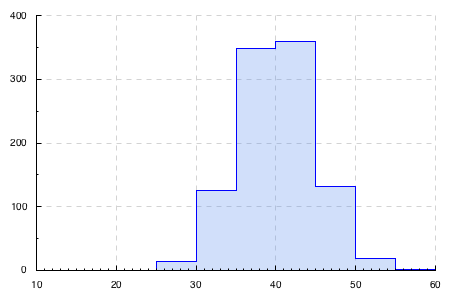

In [33]:
randomTree = alphHuffmanTree (NonEmpty.fromList randomVars :: NonEmpty Int)

sampled <- evalRandIO (replicateM 1000 (select randomTree))

contHist 5 10 (map toEnum sampled)

There are a few ways this kind of sampling can be used:

* If an algorithm provides $\epsilon _1$-differential privacy, for a database with $n$ rows, running the same algorithm on the sampled version provides $\epsilon _2$-differential privacy, where

   $$\epsilon _2 = \ln (1 + \frac{e ^{\epsilon _1} - 1}{n})$$

   <cite data-cite="2201627/5IMLZ4IX"></cite>

* Linking with $k$-anonymity, the differential privacy provided by a sampling algorithm is intrinsically linked with the number of "rare" values in the table <cite data-cite="2201627/EWE8SB6Y"></cite>. The tree can be used to prune rare values effectively.

* <cite data-cite="2201627/HHZU28FT"></cite> showed that a given $k$ anonymity algorithm can satisfy $(\epsilon, \delta)$-differential privacy when preceded with a random sampling step (under certain conditions).

* In <cite data-cite="2201627/8UZ939PH"></cite>, an algorithm where each row of the database is replaced by a weighted randomized response is shown to satisfy certain privacy guarantees. This is readily adaptable to be run on the tree.

* <cite data-cite="2201627/R9SECCIQ"></cite> examined the general problem of using hierarchical methods for releasing differentially private histograms. Both the questions of branching factor and how the privacy budget is allocated between levels of the tree are examined.

* <cite data-cite="2201627/EE8IAKHD"></cite> provides an algorithm very similar to mondrian, which partitions data (similar to $kd$-tree construction), and perturbs the buckets before releasing.

In general, these algorithms build a histogram (the cleverest seem to use $kd$-tree methods to partitions the data). They either apply perturbation before or after building the histogram. The third approach uses a kind of random-response method, which would preserve some ordering in the output. I have not seen a bottom-up approach for building the trees.